# アンサンブル学習

### 確率質量関数

In [21]:
import enserr

enserr.ensemble_error(n_classifier = 11, error = 0.25)

0.034327507019042969

個々の分類器の誤分類率(0.25)よりも小さくなっている

### アンサンブルとベース分類器の誤分類の関係

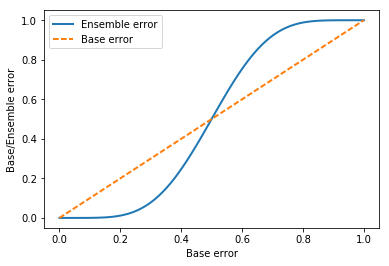

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [enserr.ensemble_error(n_classifier = 11, error = error) for error in error_range]

plt.plot(error_range, ens_errors, label = 'Ensemble error', linewidth = 2)
plt.plot(error_range, error_range, linestyle = '--', label = 'Base error', linewidth = 2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.show()

$\epsilon < 0.5$の時，アンサンブルの誤分類率がベース分類器の誤分類率に勝る

### 単純な多数決分類器の実装

重み付き多数決

In [6]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], weights = [0.2, 0.2, 0.6]))

1

クラスの確立に基づく重み付き多数決

In [9]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[ 0.58  0.42]
0


### 多数決方式の分類アルゴリズムを組み合わせる

In [12]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1)

ロジスティック回帰・決定木分類・k近傍分類器

In [13]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty = 'l2', C = 0.001, random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = 'entropy', random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


### 個々の分類器の組み合わせ

In [14]:
import mvc

mv_clf = mvc.MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10, scoring = 'roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label)) 

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


個々の分類器の性能を上回っている

## アンサンブル分類器の評価とチューニング

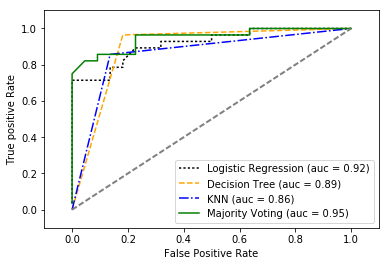

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = '%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.show()

決定領域のプロット

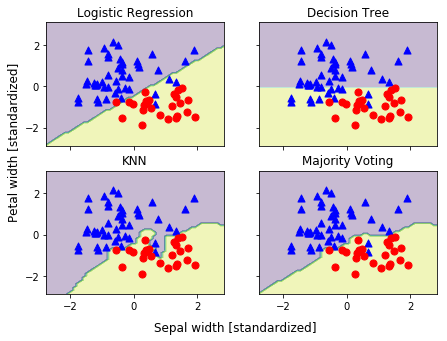

In [40]:
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2, sharex = 'col', sharey = 'row', figsize = (7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c = 'blue',
                                  marker = '^',
                                  s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c = 'red',
                                  marker = 'o',
                                  s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s = 'Sepal width [standardized]', ha = 'center', va = 'center', fontsize = 12)
plt.text(-10.5, 4.5, s = 'Petal width [standardized]', ha = 'center', va = 'center', fontsize = 12, rotation = 90)
plt.show()


In [19]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

チューニング
- ロジスティック回帰の逆正則化パラメータC
- 決定木の深さ

In [22]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator = mv_clf, param_grid = params, cv = 10, scoring = 'roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solv...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [29]:
cv_keys = ('mean_test_score', 'std_test_score','params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r" % (grid.cv_results_[cv_keys[0]][r], 
                                   grid.cv_results_[cv_keys[1]][r] / 2.0, 
                                   grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


## バギング

Wineデータセットの読み込み

In [1]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

クラスラベルを二値でエンコード
- トレーニングデータセット：60%
- テストデータセット：40%

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.40,
                                                    random_state = 1)

ブートストラップ標本で学習

In [33]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = None,
                              random_state = 1)
bag = BaggingClassifier(base_estimator = tree,
                        n_estimators = 500,
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap = True,
                        bootstrap_features = False,
                        n_jobs = 1,
                        random_state = 1)

予測の正解率

In [35]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


上の結果は過学習っぽい

In [44]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.896


汎化性能はバギング分類器の方が上回っている

### 決定領域の比較

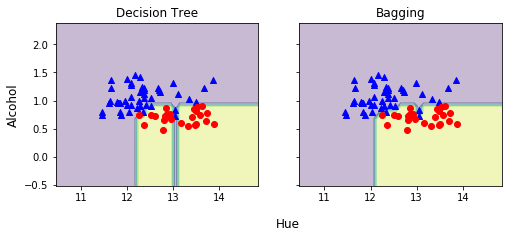

In [47]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2,
                        sharex = 'col',
                        sharey = 'row',
                        figsize = (8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                                  X_train[y_train == 0, 1],
                                  c = 'blue',
                                  marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                                  X_train[y_train == 1, 1],
                                  c = 'red',
                                  marker = 'o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2, s = 'Hue', ha = 'center', va = 'center', fontsize = 12)
plt.show()

## アダブーストによる弱学習器の活用

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(criterion = 'entropy',
                              max_depth = 1,
                              random_state = 0)
ada = AdaBoostClassifier(base_estimator = tree,
                         n_estimators = 500,
                         learning_rate = 0.1,
                         random_state = 0)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Descision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Descision tree train/test accuracies 0.845/0.854


In [19]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.875


### 決定領域

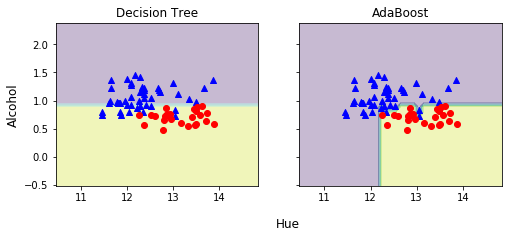

In [23]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2,
                        sharex = 'col',
                        sharey = 'row',
                        figsize = (8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                                  X_train[y_train == 0, 1],
                                  c = 'blue',
                                  marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                                  X_train[y_train == 1, 1],
                                  c = 'red',
                                  marker = 'o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2, s = 'Hue', ha = 'center', va = 'center', fontsize = 12)
plt.show()